In [1]:
# https://huggingface.co/docs/transformers/tasks/object_detection

In [6]:
import os
from transformers import AutoImageProcessor, YolosImageProcessor
import albumentations
import numpy as np
from PIL import Image
from transformers import AutoModelForObjectDetection
from transformers import TrainingArguments
from transformers import Trainer
from transformers import pipeline
from PIL import Image
from transformers import AutoImageProcessor, AutoModelForObjectDetection, YolosImageProcessor
import torch
from PIL import ImageDraw
from datasets import load_dataset
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "7"

# define dataset and fine-tune model

In [8]:
base_dir = '/usr/users/henrich1/exercises_summer_school/data/object_detection'
train_path = os.path.join(base_dir, 'train.csv')
val_path = os.path.join(base_dir, 'val.csv')
data_files = {
    'train': train_path,
    'val': val_path
}

dataset = load_dataset("csv", data_files=data_files)
print(dataset['train'])
print(dataset['val'])

id2label = {0: 'pig'}
label2id = {'pig': 0}

Dataset({
    features: ['image_id', 'image_name'],
    num_rows: 873
})
Dataset({
    features: ['image_id', 'image_name'],
    num_rows: 98
})


In [9]:
# image processor
checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)


# augmentations
transform = albumentations.Compose(
    [
        # albumentations.Resize(400, 640),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.RandomBrightnessContrast(p=0.5),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)


# annotation format
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(len(category)):

        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0, # no background class
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [10]:
def transform_aug_ann(examples, base_dir):
    images_dir = os.path.join(base_dir, 'images')
    labels_dir = os.path.join(base_dir, 'labels')
    image_ids = examples["image_id"]
    images, bboxes, areas, categories = [], [], [], []
    
    for image_name in examples["image_name"]:
        image = Image.open(os.path.join(images_dir, image_name + '.jpg'))
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        
        bbox = np.loadtxt(os.path.join(labels_dir, image_name + '.txt'))
        if bbox.ndim == 1:
            bbox = bbox[None, :]
        category = [0 for _ in range(len(bbox))] # only one class
        out = transform(image=image, bboxes=bbox, category=category)
        area = np.array(out["bboxes"])[:, 2] * np.array(out["bboxes"])[:, 3]

        areas.append(area)
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, areas, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [11]:
dataset['train'] = dataset['train'].with_transform(lambda examples: transform_aug_ann(examples, base_dir))
dataset['train'][0]


{'pixel_values': tensor([[[-0.3883, -0.5082, -0.5767,  ..., -0.0629, -0.0287, -0.0458],
          [-0.7993, -0.6794, -0.4911,  ..., -0.1828,  0.0398,  0.2111],
          [-0.3883, -0.3541, -0.2856,  ..., -0.1314,  0.0056,  0.0569],
          ...,
          [-1.5870, -1.5870, -1.5870,  ..., -1.1760, -1.4500, -1.3302],
          [-1.6042, -1.6042, -1.6042,  ..., -1.2103, -1.3302, -1.3644],
          [-1.6042, -1.6042, -1.6042,  ..., -1.2959, -1.2445, -1.4329]],
 
         [[-0.2850, -0.4076, -0.4776,  ..., -0.4426, -0.5126, -0.5826],
          [-0.7052, -0.5826, -0.3901,  ..., -0.5476, -0.4426, -0.3375],
          [-0.2850, -0.2500, -0.1800,  ..., -0.4951, -0.4776, -0.4426],
          ...,
          [-1.1954, -1.1954, -1.1954,  ..., -1.0028, -1.3179, -1.2304],
          [-1.2129, -1.2129, -1.2129,  ..., -1.0378, -1.1954, -1.2654],
          [-1.2129, -1.2129, -1.2129,  ..., -1.1253, -1.1078, -1.3354]],
 
         [[-0.6541, -0.7761, -0.8458,  ..., -0.4624, -0.5147, -0.5670],
          [-

In [12]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["labels"] = labels
    return batch

In [13]:
model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [12]:
training_args = TrainingArguments(
    output_dir="detr-resnet-50_finetuned_pigs",
    per_device_train_batch_size=6,
    num_train_epochs=50,
    fp16=True,
    save_steps=200,
    logging_steps=200,
    learning_rate=1e-4,
    weight_decay=1e-4,
    save_total_limit=20,
    remove_unused_columns=False,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=dataset["train"],
    tokenizer=image_processor,
)

trainer.train()

# inference

In [31]:
path = '/usr/users/henrich1/exercises_summer_school/data/object_detection/images/K420200124-144924-1579873764_frame_364.jpg'
image = Image.open(path)

obj_detector = pipeline("object-detection", model="/usr/users/henrich1/exercises_summer_school/exercises/object_detection/final/detr-resnet-50_finetuned_pigs/checkpoint-7200")
results = obj_detector(image)

In [32]:
results

[{'score': 0.9972368478775024,
  'label': 'pig',
  'box': {'xmin': 74, 'ymin': 18, 'xmax': 279, 'ymax': 152}},
 {'score': 0.9732513427734375,
  'label': 'pig',
  'box': {'xmin': 844, 'ymin': 633, 'xmax': 1099, 'ymax': 798}},
 {'score': 0.9982582926750183,
  'label': 'pig',
  'box': {'xmin': 1013, 'ymin': 478, 'xmax': 1227, 'ymax': 663}},
 {'score': 0.9926344752311707,
  'label': 'pig',
  'box': {'xmin': 629, 'ymin': 697, 'xmax': 875, 'ymax': 796}},
 {'score': 0.9981188178062439,
  'label': 'pig',
  'box': {'xmin': 860, 'ymin': 447, 'xmax': 1123, 'ymax': 544}},
 {'score': 0.998711347579956,
  'label': 'pig',
  'box': {'xmin': 4, 'ymin': 175, 'xmax': 110, 'ymax': 466}},
 {'score': 0.9992603659629822,
  'label': 'pig',
  'box': {'xmin': 24, 'ymin': 445, 'xmax': 120, 'ymax': 705}},
 {'score': 0.998569130897522,
  'label': 'pig',
  'box': {'xmin': 1070, 'ymin': 515, 'xmax': 1258, 'ymax': 695}},
 {'score': 0.9992614388465881,
  'label': 'pig',
  'box': {'xmin': 1051, 'ymin': 297, 'xmax': 124

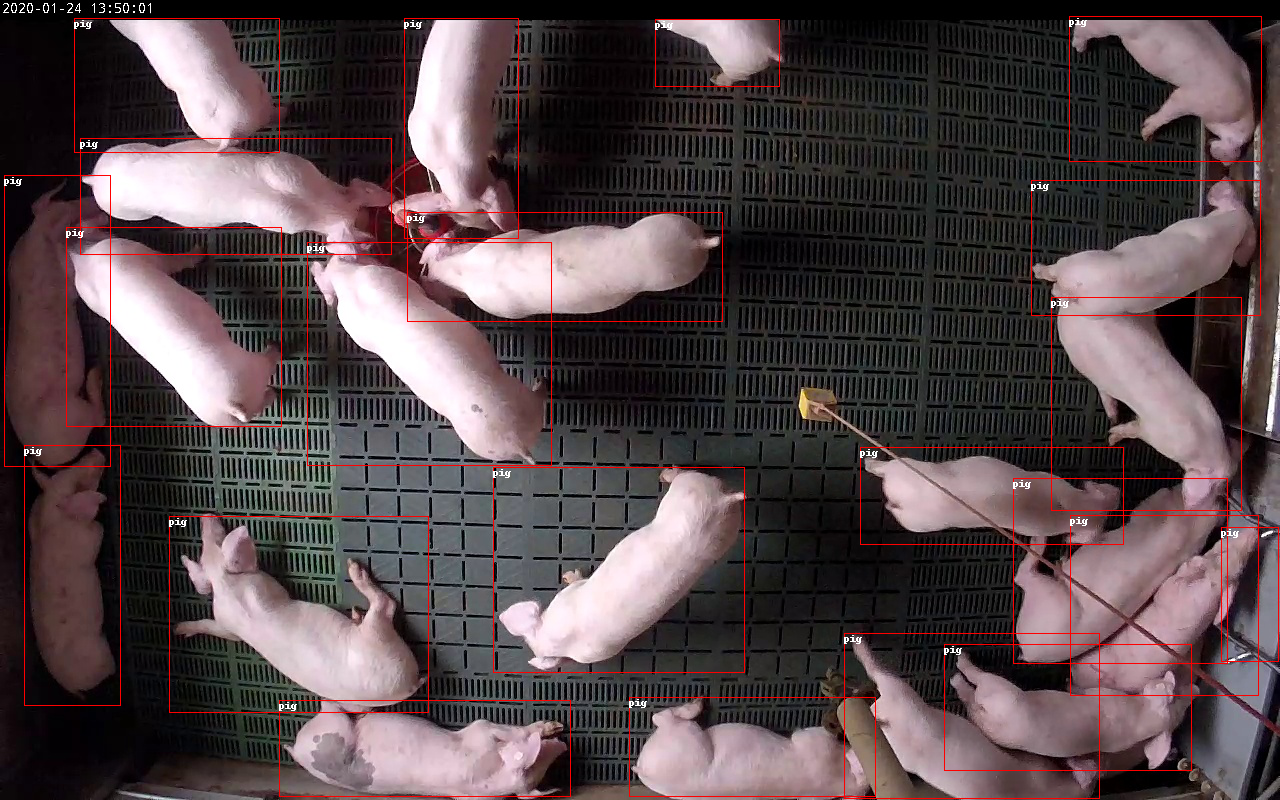

In [33]:
draw = ImageDraw.Draw(image)

for result in results:
    score = result['score']
    label = result['label']
    box = result['box']
    box = [round(i, 2) for i in list(box.values())]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    draw.text((x, y), label, fill="white")

image